Anna Wojciechowska, Oslo, July 2024  
test details:  
salt water test in Oslo Fjord, comparisiont to kartverket havniva  
Kartverket measuremnts from probably Akkerbrygge  
date: 7th July 2024   
place: Sjølyst Marina    
GPS: 59.900131 Lat 10.716573 Lon
![photo](./sjolyst.jpg)  


In [1]:
#requriements
#scipy==1.8.0
#statsmodels==0.13.5
#numpy==1.24.4

In [2]:
import json
from influxdb import InfluxDBClient

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import date
from datetime import timedelta
from datetime import datetime as dt

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf  # module to run ordinary least squares analysis
from scipy import stats

In [3]:
influx_auth = json.load(open('./influxdb_credentials'))
TIDES_CLIENT = InfluxDBClient(
    host="localhost",
    username=influx_auth['username'],
    password=influx_auth['password'],
    port=8086,
    database="tide_info")
SENSOR_CLIENT = InfluxDBClient(
    host="localhost",
    username=influx_auth['username'],
    password=influx_auth['password'],
    port=8086,
    database="sensor")
q = f"SHOW MEASUREMENTS"
df = pd.DataFrame(TIDES_CLIENT.query(q).get_points())
df

,name
0,missing_data
1,tide_level
2,tide_stations


In [4]:
q = f"SHOW MEASUREMENTS"
df = pd.DataFrame(SENSOR_CLIENT.query(q).get_points())
df

,name
0,pressure
1,sensor_locations
2,sensor_test
3,world_tides


In [5]:
start_time = '2024-07-27T19:39:00Z'
end_time = '2024-07-28T10:23:00Z'
q = f"SELECT * FROM tide_level WHERE siteName = 'OSL' AND time > '{start_time}' and time < '{end_time}'"
tide_df = pd.DataFrame(TIDES_CLIENT.query(q).get_points())
tide_df['time'] = pd.to_datetime(tide_df['time'])
tide_df.set_index('time', inplace=True)
tide_df.head(3)

,level,referenceLevel,siteName
time,,,
2024-07-27 19:40:00+00:00,94.5,CD (Chart Datum),OSL
2024-07-27 19:50:00+00:00,95.8,CD (Chart Datum),OSL
2024-07-27 20:00:00+00:00,97.3,CD (Chart Datum),OSL


# In order to compare 2 datasets I need to do "time collocation", both datasets need to to have aligned timestamps

In [6]:
q = f"SELECT * FROM sensor_test WHERE sensor_position = 'SALTSTEIN_W' and  time > '{start_time}' and time < '{end_time}'"
sensor_df = pd.DataFrame(SENSOR_CLIENT.query(q).get_points())
sensor_df['time'] = pd.to_datetime(sensor_df['time'])
sensor_df.set_index('time', inplace=True)
resampled_series = sensor_df.resample('10T')['pressure_mbar'].mean()
del sensor_df
sensor_df = resampled_series.to_frame()
sensor_df = sensor_df.drop(index=sensor_df.index[0])
sensor_df.head(2)

,pressure_mbar
time,
2024-07-27 19:40:00+00:00,1325.362833
2024-07-27 19:50:00+00:00,1326.980583


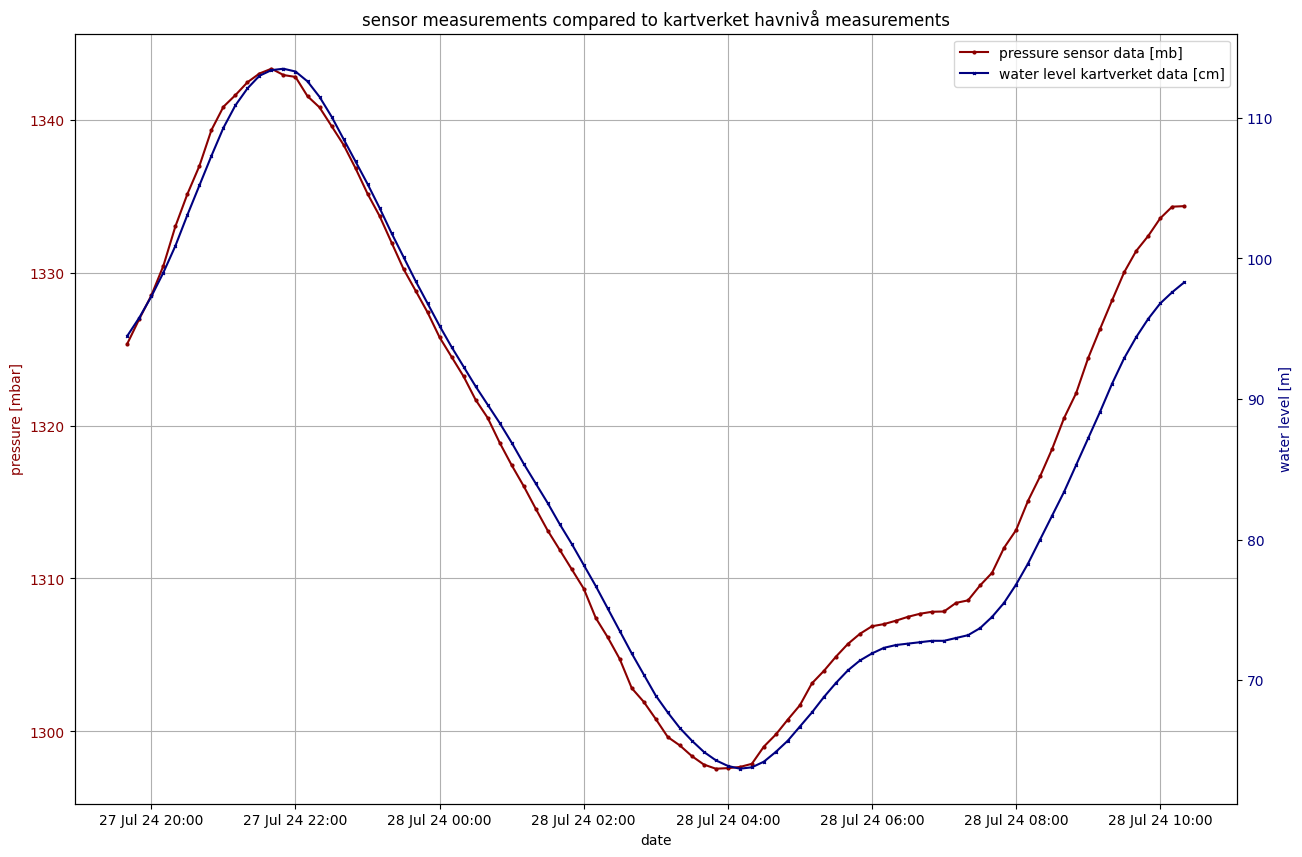

In [7]:
fig, ax1 = plt.subplots(figsize=(15, 10))

date_format = mdates.DateFormatter('%d %b %y %H:%M')  
ax1.xaxis.set_major_formatter(date_format)

ax1.plot(sensor_df.index, sensor_df['pressure_mbar'], color='darkred', marker='o', markersize=2, label = 'pressure sensor data [mb]')
ax1.set_xlabel('date')
ax1.set_ylabel('pressure [mbar]', color='darkred')
ax1.tick_params(axis='y', labelcolor='darkred')

ax2 = ax1.twinx()
ax2.plot(tide_df.index, tide_df['level'], color='navy', marker='x', markersize=2, label = 'water level kartverket data [cm]')
ax2.set_ylabel('water level [m]', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

plt.title('sensor measurements compared to kartverket havnivå measurements')
handle1, label1 = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handle1 + handle2, label1 + label2, loc='upper right')
ax1.grid(True)
#fig.savefig('sensor_vs_kartverket.png', dpi=100, bbox_inches='tight')

fig, ax1 = plt.subplots(figsize=(15, 10))

date_format = mdates.DateFormatter('%d %b %y %H:%M')  
ax1.xaxis.set_major_formatter(date_format)

handle1 = ax1.plot(sensor_df.index, sensor_df['pressure_mbar'], color='darkred', marker='o', markersize=2, label = 'pressure sensor data [mb]')
ax1.set_xlabel('date')
ax1.set_ylabel('pressure [mbar]', color='darkred')
ax1.tick_params(axis='y', labelcolor='darkred')

ax2 = ax1.twinx()
handle2 = ax2.plot(tide_df.index, tide_df['level'], color='navy', marker='x', markersize=2, label = 'water level kartverket data [cm]')
ax2.set_ylabel('water level [m]', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

plt.title('sensor measurements compared to kartverket havnivå measurements')
ax1.legend( handles=handle1+handle2 )
ax1.grid(True)
plt.ioff()
fig.savefig('sensor_vs_kartverket.png', dpi=300, bbox_inches='tight')
plt.close(fig)    
#plt.savefig('sensor_vs_kartverket.png', dpi=300, bbox_inches='tight')
#plt.show()

In [8]:
cutoff_datetime = pd.Timestamp('2024-07-28 04:00', tz='UTC')
tide_subset_df= tide_df[tide_df.index < cutoff_datetime]
sensor_subset_df= sensor_df[sensor_df.index < cutoff_datetime]
merged_df = pd.merge(tide_subset_df, sensor_subset_df, left_index=True, right_index=True)
merged_df.head(2)

,level,referenceLevel,siteName,pressure_mbar
time,,,,
2024-07-27 19:40:00+00:00,94.5,CD (Chart Datum),OSL,1325.362833
2024-07-27 19:50:00+00:00,95.8,CD (Chart Datum),OSL,1326.980583


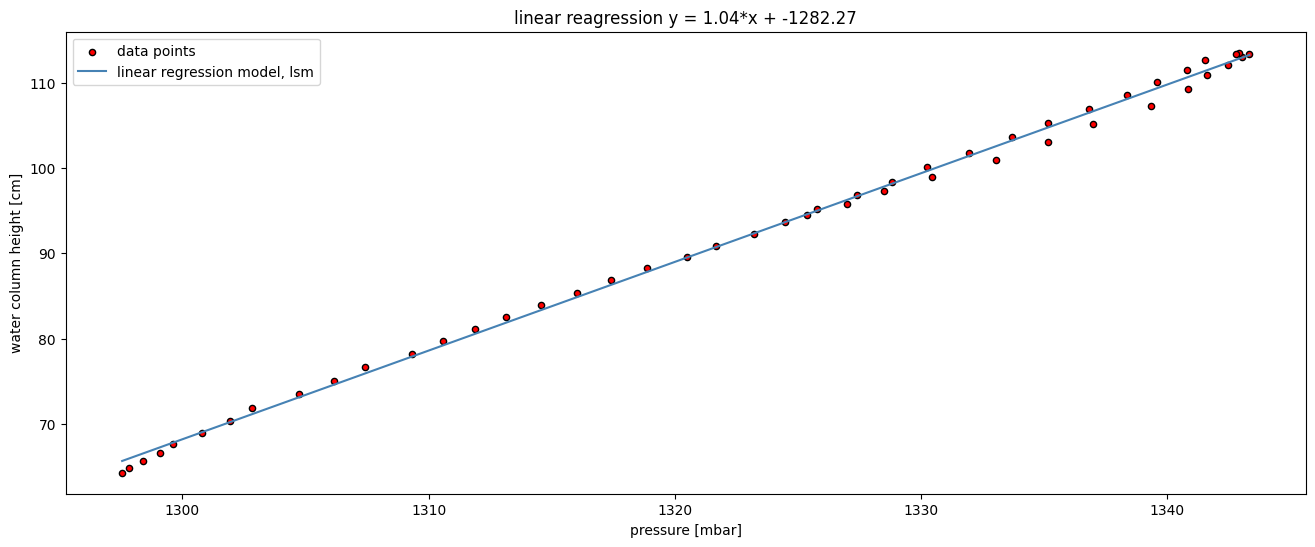

In [9]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(x=merged_df['pressure_mbar'],y=merged_df['level'],s=20,alpha=1,marker='o', color = 'red', edgecolor = 'black',  label  = 'data points')

#linear regression part
linfit = smf.ols(formula=' level ~ pressure_mbar', data=merged_df).fit()
intercept, slope = linfit.params

x = np.linspace(merged_df['pressure_mbar'].min(), merged_df['pressure_mbar'].max(), 50)
y = intercept + slope*x
ax.plot(x,y, 'steelblue', label = 'linear regression model, lsm')
ax.set_xlabel('pressure [mbar]')
ax.set_ylabel('water column height [cm]')
ax.set_title(f'linear reagression y = {round(slope,2)}*x + {round(intercept,2)}')
_= ax.legend()
#fig.savefig('lin_reg.png', dpi=100, bbox_inches='tight')

In [10]:
intercept

-1282.2732362885658

In [11]:
sensor_df['linear_water_level'] = sensor_df['pressure_mbar']* slope + intercept
sensor_df['diff_from_havniva'] = abs(sensor_df['linear_water_level'] - tide_df['level'])
sensor_df.head(2)

,pressure_mbar,linear_water_level,diff_from_havniva
time,,,
2024-07-27 19:40:00+00:00,1325.362833,94.566673,0.066673
2024-07-27 19:50:00+00:00,1326.980583,96.247256,0.447256


In [12]:
min = round(sensor_df['diff_from_havniva'].min(), 2)
max = round(sensor_df['diff_from_havniva'].max(), 2)
mean = round(sensor_df['diff_from_havniva'].mean(), 2)

min, max, mean
#sensor_df['diff_from_havniva'].min(),sensor_df['diff_from_havniva'].max(), sensor_df['diff_from_havniva'].mean()

(0.03, 6.51, 2.27)

In [13]:
max-mean, mean-min

(4.24, 2.24)

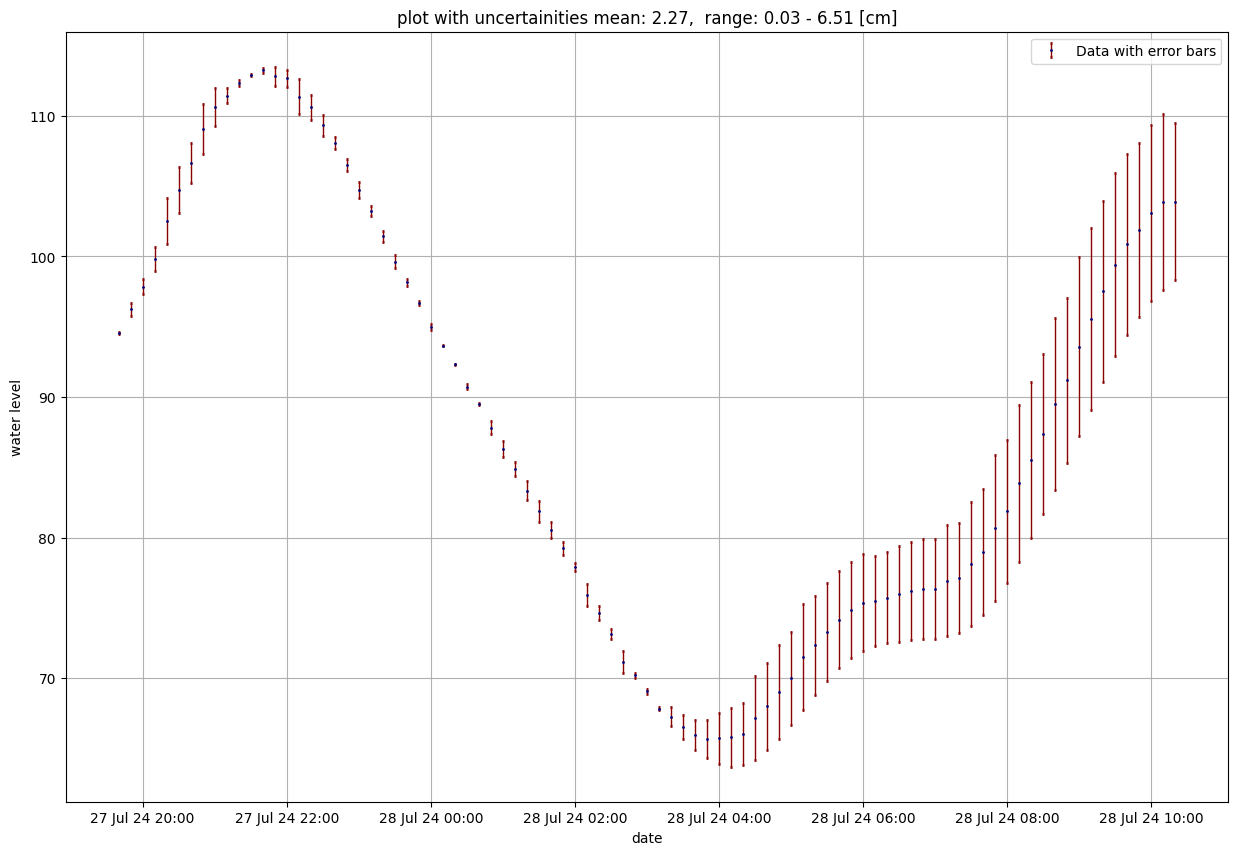

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

date_format = mdates.DateFormatter('%d %b %y %H:%M')  
ax.xaxis.set_major_formatter(date_format)
ax.errorbar(sensor_df.index, sensor_df['linear_water_level'], yerr= sensor_df['diff_from_havniva'], fmt='o', markersize=1, capsize=1, capthick=2, elinewidth=1, color='navy', ecolor='darkred', label='Data with error bars')
ax.set_xlabel('date')
ax.set_ylabel('water level')
ax.set_title(f'plot with uncertainities mean: {mean},  range: {min} - {max} [cm]')
ax.legend()
ax.grid(True)     